In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.multiprocessing.spawn import spawn
import torchvision.models as models
import torchvision.datasets as dst
from torchvision.io import read_image
from torchvision.transforms import v2

In [4]:
# settings
DATA_A_PATH = "/export/space0/yanai/media/foodimg128/rice/img0001.jpg"
DATA_B_PATH = "/export/space0/yanai/media/foodimg128/unadon/"

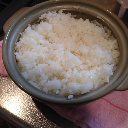

In [5]:
a = Image.open(DATA_A_PATH)
a

In [2]:
def transform_image(img):
    transforms = v2.Compose([
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])
    return transforms(img)


class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
        )
    def forward(self, x):
        return x + self.conv(x)


class Generator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, ngf=64, n_blocks=9):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, ngf, 7),
            nn.InstanceNorm2d(ngf), nn.ReLU(True),
            # down‑sample ×2
            *self._down(ngf, ngf*2),
            *self._down(ngf*2, ngf*4),
            # residual blocks
            *[ResnetBlock(ngf*4) for _ in range(n_blocks)],
            # up‑sample ×2
            *self._up(ngf*4, ngf*2),
            *self._up(ngf*2, ngf),
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, out_ch, 7), nn.Tanh()
        ]
        self.model = nn.Sequential(*layers)
    def _down(self, in_c, out_c):
        return [nn.Conv2d(in_c, out_c, 3, 2, 1),
                nn.InstanceNorm2d(out_c), nn.ReLU(True)]
    def _up(self, in_c, out_c):
        return [nn.ConvTranspose2d(in_c, out_c, 3, 2, 1, 1),
                nn.InstanceNorm2d(out_c), nn.ReLU(True)]
    def forward(self, x): return self.model(x)

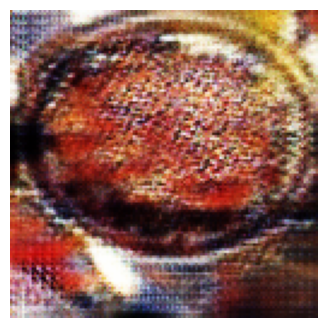

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data
data_path = "/export/space0/yanai/media/foodimg128/rice/img0001.jpg"
img = read_image(data_path)
img = transform_image(img)
img = img.unsqueeze(0).to(device).float()

# model
model = Generator()
model.load_state_dict(torch.load("10_1_cycle_gan.pth"))
model = nn.DataParallel(model.to(device))

model.eval()
with torch.no_grad():
    styled_img = model(img)

# 可視化
def reprocessing(img):
    if img.ndim == 3:      # (C,H,W) → (1,C,H,W) に合わせる
        img = img.unsqueeze(0)
    img = (img + 1.) / 2.          
    return img.clamp(0,1).squeeze(0) #clamp()は念の為

vis = reprocessing(styled_img)
plt.figure(figsize=(4,4))
plt.imshow(vis.cpu().permute(1,2,0))
plt.axis('off')
plt.show()

In [ ]:
vis

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9998],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9999, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9999, 0.9983],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9990, 0.9990, 0.9986],
         [0.9999, 0.9994, 1.0000,  ..., 0.9982, 0.9988, 0.9995],
         [0.9997, 1.0000, 0.9997,  ..., 0.9992, 0.9970, 0.9991]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9998, 0.9996],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9997],
         [1.0000, 1.0000, 1.0000,  ..., 0.9999, 0.9988, 0.9997],
         ...,
         [0.9999, 0.9999, 1.0000,  ..., 0.9989, 0.9993, 0.9967],
         [0.9991, 1.0000, 0.9999,  ..., 0.9987, 0.9991, 0.9977],
         [0.9999, 0.9998, 0.9996,  ..., 0.9988, 0.9990, 0.9972]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9993, 1.0000, 0.9996],
         [1.0000, 1.0000, 1.0000,  ..., 0.9936, 0.9995, 0.9967],
         [1.0000, 1.0000, 1.0000,  ..., 0.9996, 0.9999, 0.

: 